In [2]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 106147715 / Gaia DR3 5440547120952900736 Analysis (EA)


## TESS Data



In [3]:
tic = 106147715

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

lcc_tess = sr.download_all()
lcc_tess

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 09,2019,TESS-SPOC,1800,106147715,0.0,N/A
1,TESS Sector 63,2023,SPOC,120,106147715,0.0,N/A


LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 106147715" SECTOR=9 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 106147715" SECTOR=63 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

In [4]:
# List of all TCEs of the TIC
display(HTML(lket.get_tic_meta_in_html(tic, download_dir=lk_download_dir)))

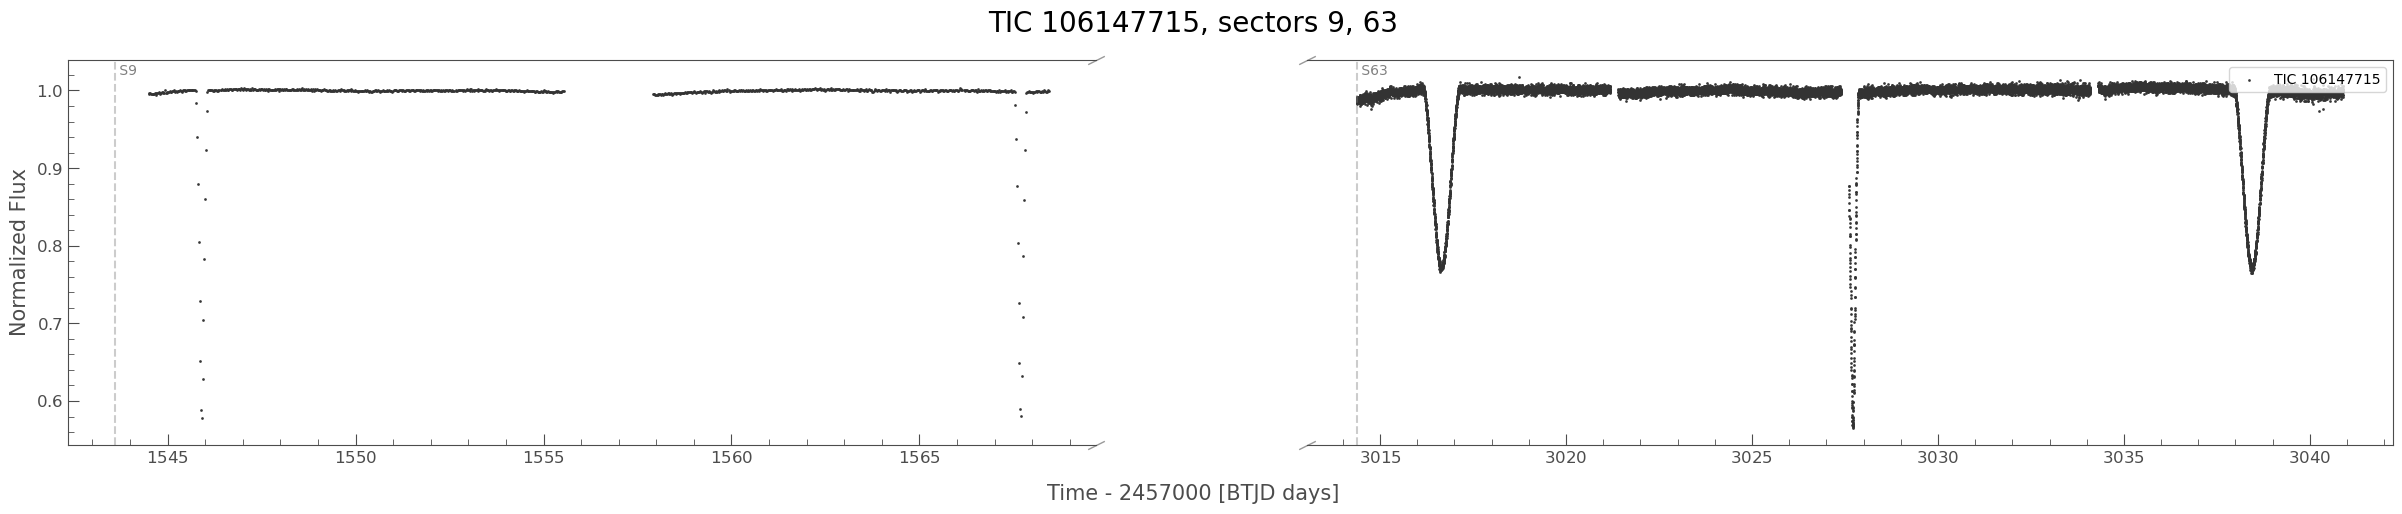

In [5]:
lc = lke.stitch(
    lcc_tess,
    ignore_incompatible_column_warning=True,    
)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=4, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);

---

## Gaia DR3 info (coordinate, etc.)

In [6]:
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)


In [7]:
primary_name = f"Gaia DR3 5440547120952900736"  # Gaia DR3 Variable has already published about it, even though the data used is from TESS and ASAS-SN


## ASAS-SN data

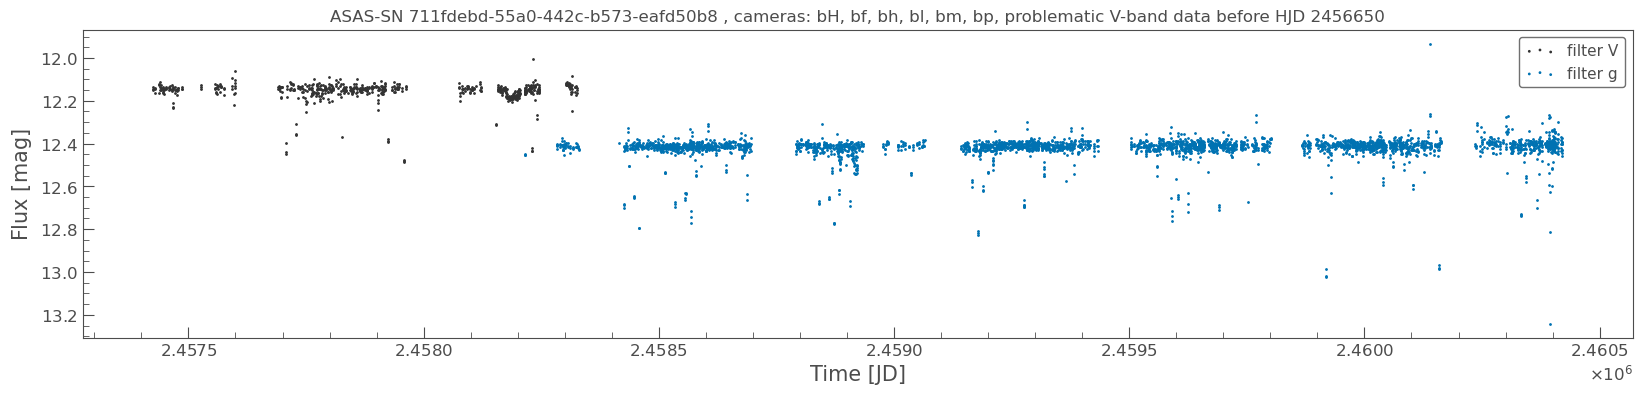

In [8]:
import lightkurve_ext_readers as lker
reload(lker)

# SkyPatrol v1 , its result has more scatter
# https://asas-sn.osu.edu/sky-patrol/coordinate/f4603ce4-bbce-4fe8-892b-4a68fae4464c
lc = (
    lker.read_asas_sn_csv(f"{lk_download_dir}/targets/tic106147715_asas_sn_light_curve_711fdebd-55a0-442c-b573-eafd50b8e77c.csv")
    .select_flux("mag")
)

ax = tplt.lk_ax(figsize=(20, 4))
ax = tplt.scatter_partition_by(lc, "filter", ax=ax);
ax.set_title(ax.get_title() + ", problematic V-band data before HJD 2456650");

lc_asassn = lc  # keep the reference in a meaninfgul name for use in subsequent cells

## Combining TESS and ASAS-SN data

TESS # data points: 19493
ASAS-SN V # data points: 634
ASAS-SN g # data points: 3419


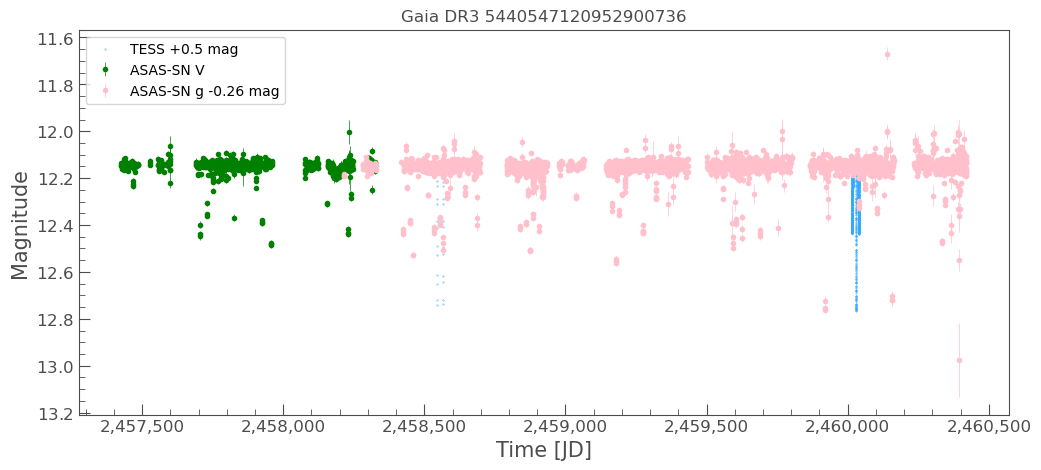

In [9]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
reload(lkem)

lc_tess = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True,    )

lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)
# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
     "ASAS-SN": lc_asassn,
    }, 
    shift_to="ASAS-SN V")

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name);


## Determine period by using both TESS and ASAS-SN data

In [10]:
# epoch=3287.5580, duration_hr=3.3745, period=2.039652, label="s0073-s0073:TCE1",

#
# Tentative Eclipse parameters, from s0003-s0073:TCE1 above
#

period_initial = 21.79135

epoch_time_btjd = 3027.712
epoch_time_hjd = lke.to_hjd_utc(Time(epoch_time_btjd, format="btjd"), target_coord).value
epoch_time_hjd = round(epoch_time_hjd, 3)  # for VSX reporting, 3 digit precision (~1.44 min) is more than enough

epoch_time_min_ii_btjd = 3016.65
epoch_time_min_ii_hjd = lke.to_hjd_utc(Time(epoch_time_min_ii_btjd, format="btjd"), target_coord).value
epoch_time_min_ii_hjd = round(epoch_time_min_ii_hjd, 3)  # for VSX reporting, 3 digit precision (~1.44 min) is more than enough

duration_hr_min_i_initial = 7.2  
duration_hr_min_ii_initial = 22.5
duration_hr = duration_hr_min_i_initial   # default shorthand 

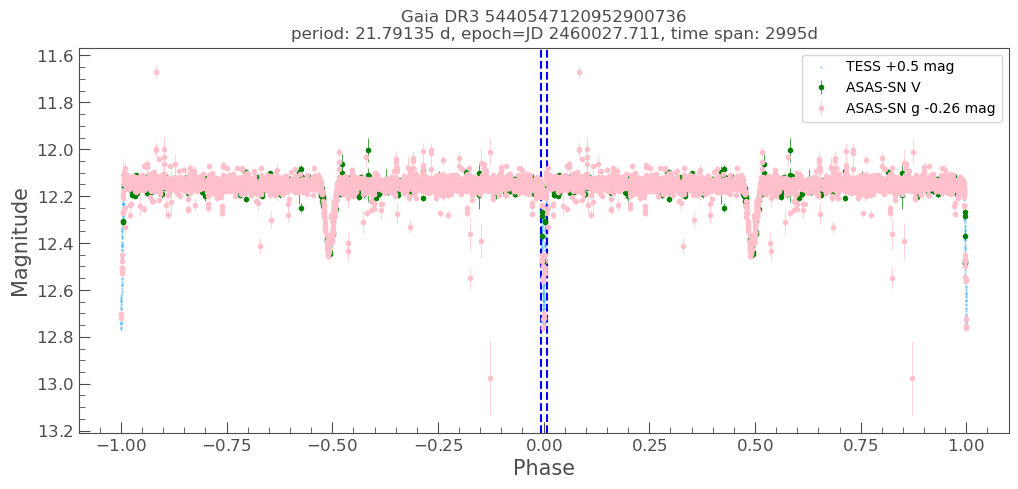

In [17]:
%matplotlib inline
# %matplotlib widget

reload(lkem)
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_initial,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_initial,  # for plotting only
    figsize=(12, 5),
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway 

);

# ax.set_ylim(11.85, 11.65);
# ax.set_xlim(-0.1, 0.1);  # to see primary in details

C:\dev\_juypter\PH_TESS_LightCurveViewer\targets\..\lightkurve_ext_pg.py:363: UserWarning: validate_bls_n_report() cannot calculate FAP, because the depdent package transitleastsquares is not installed
  warnings.warn(


max power duration factor: 2.97


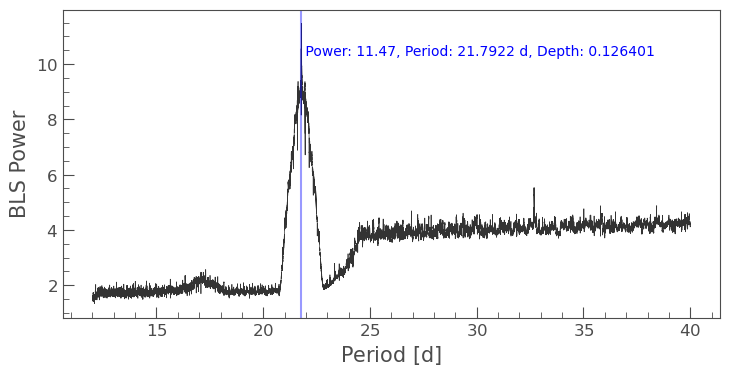

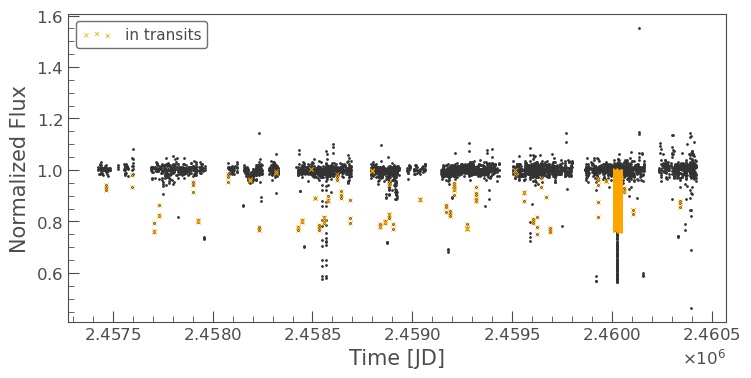

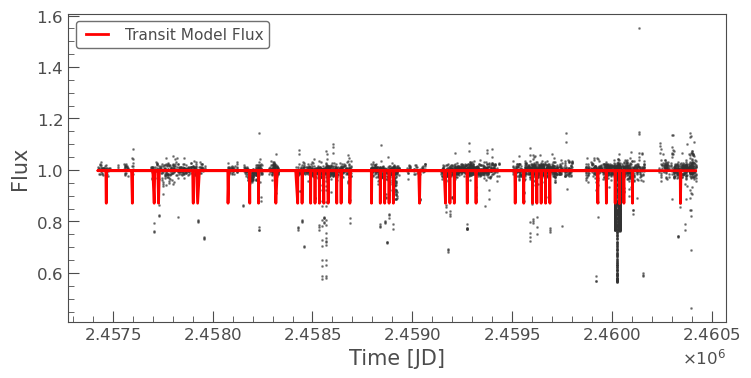

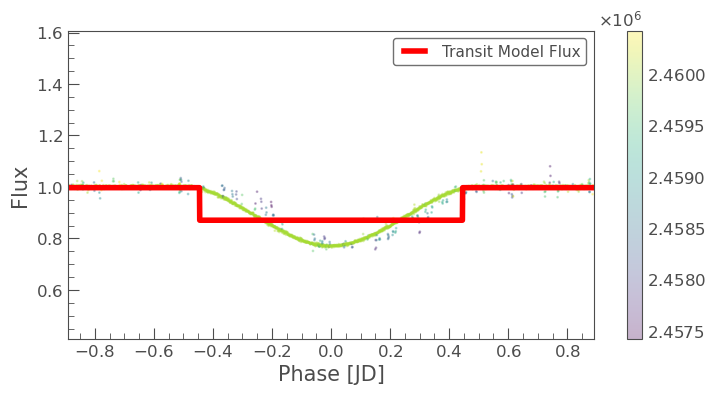

In [19]:
bls_result = lke_pg_runner.run_bls(
    # convert the combined lightcurve to normalized flux for BLS
    lke.to_normalized_flux_from_mag(lk.LightCurveCollection(lc_combined_dict.values()).stitch(corrector_func=lambda lc: lk.LightCurve(time=lc.time, flux=lc.flux, flux_err=lc.flux_err))),
    pg_kwargs=dict(
        minimum_period=12,  # avoid matching 1/2 he period
        maximum_period=40,  
        frequency_factor=2,            
        # use min_ii with the longer duration dips, BLS seems to try to fit it
        duration=[duration_hr_min_ii_initial / 24 * f for f in [0.95, 0.975, 0.9875, 1, 1.0125, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
    ),
)

print("max power duration factor:", round(bls_result.pg.duration_at_max_power.to(u.h).value / duration_hr, 2))
# tplt.beep();

In [ ]:
# export LC truncated around primary eclipses for AoV test

# lc = bls_result.lc_f.truncate(-0.25, 0.25)
# lc.scatter();
# lk.LightCurve(time=lc.time_original, flux=lc.flux, flux_err=lc.flux_err).to_csv(f"tmp/{primary_name}_trunc_primary.csv")

23546 2995.492781574435 2457424.7786 2460420.27137
Period at max: 13.1270190 d
lightkurve.Periodogram properties:
      Attribute                   Description            Units
---------------------- --------------------------------- -----
                nterms                                 1      
          default_view                            period      
             ls_method                              fast      
frequency_at_max_power                            0.0762 1 / d
             max_power                            0.0129      
               nyquist                          360.0015 1 / d
   period_at_max_power                            13.127     d
             frequency                      array (487,) 1 / d
                period                      array (487,)     d
                 power                      array (487,)      
                 label                <class 'NoneType'>      
                  meta <class 'collections.OrderedDict'>      
    

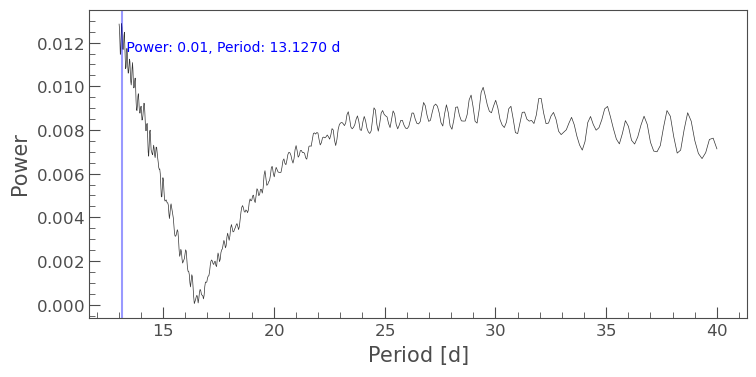

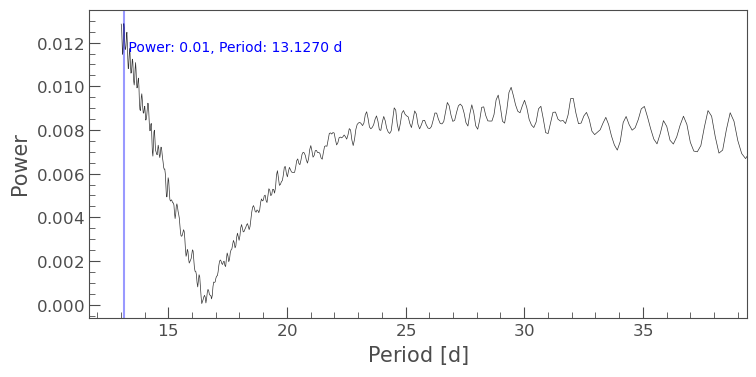

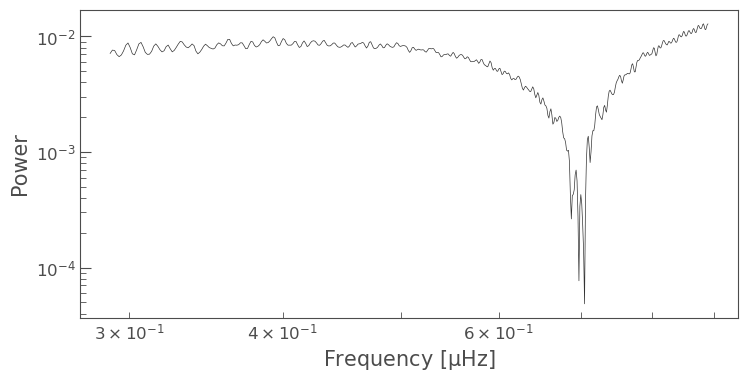

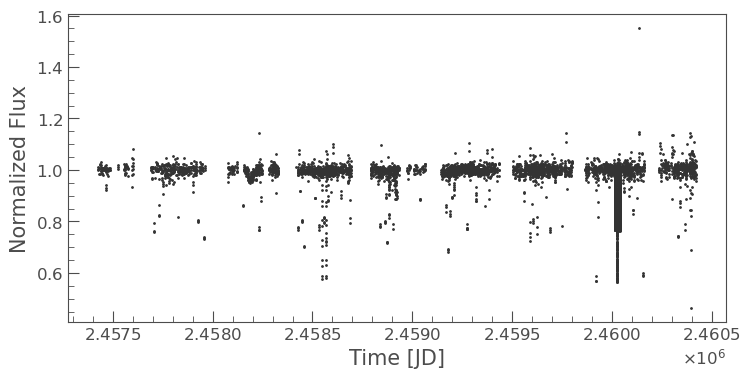

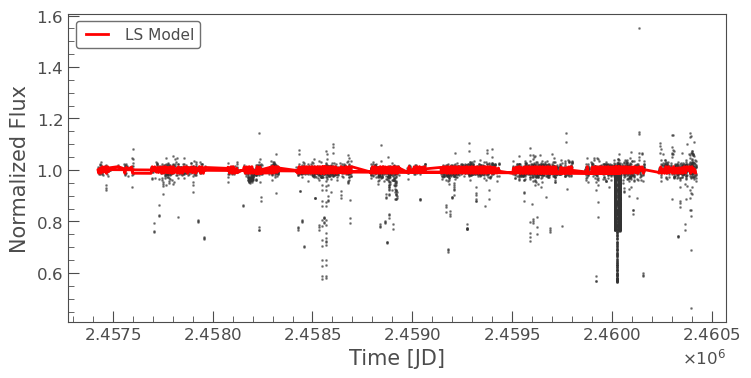

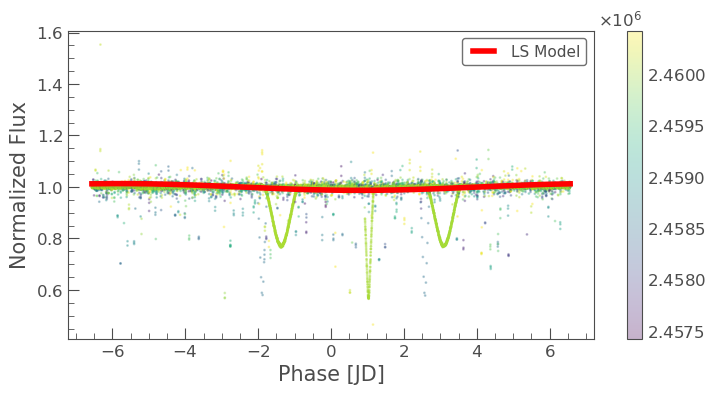

In [21]:
lc = lke.to_normalized_flux_from_mag(lk.LightCurveCollection(lc_combined_dict.values()).stitch(corrector_func=lambda lc: lk.LightCurve(time=lc.time, flux=lc.flux, flux_err=lc.flux_err)))
pg = (
    lc    
    .to_periodogram(method="lombscargle",
                      minimum_period=13,                    
                     maximum_period=40,
                    # ls_method="fastchi2", nterms=12,
                    oversample_factor=5,  # default: 5
                      )
     )
print(len(lc), lc.time.max() - lc.time.min(), lc.time.min(), lc.time.max(), )
print(f"Period at max: {pg.period_at_max_power:.7f}")
pg.show_properties();

ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=80);
# ax.set_xlim(0, 16);

# zoom in
ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=3);

# ---

# ax = pg.plot(view="frequency");  # frequency view
# ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

# frequency in log scale / microhertz
# often useful for solar type oscillator, 
ax = pg.plot(view="frequency", unit=u.microhertz, scale="log"); 

# ---

axs, lcs = lke_pg.plot_lc_with_model(
    lc.normalize(),
    pg, 
    # period=pg.period_at_max_power * 2,   # custom period
    also_return_lcs=True);

len(lc_f_min_i): 222
len(lc_f_min_ii): 1218


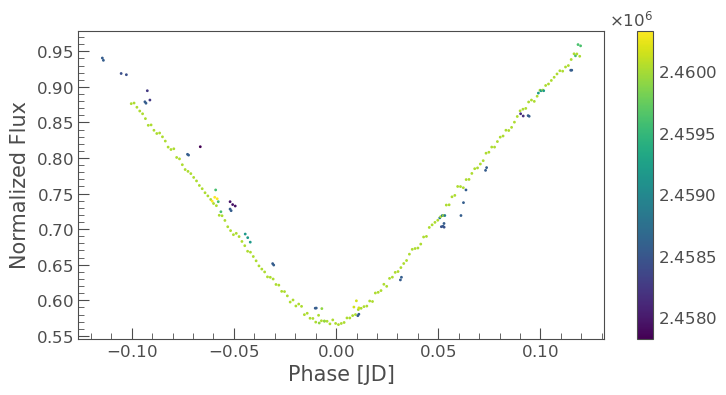

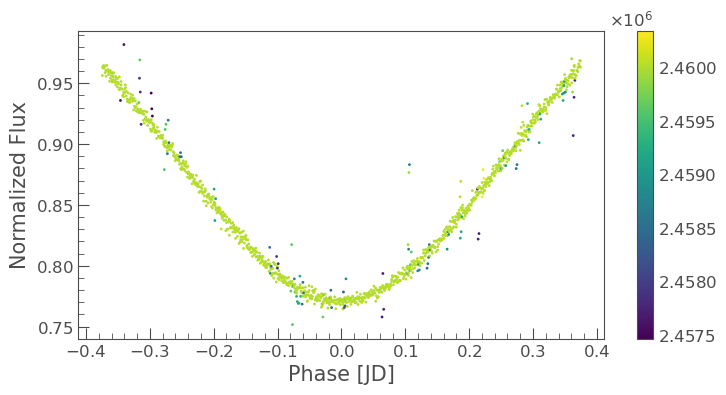

In [118]:
import sys
if "../eb_with_diff_sb_period/etv/" not in sys.path:  # for etvp
    sys.path.append("../eb_with_diff_sb_period/etv/")

import etv_functions_with_period as etvp
import etv_functions

reload(lke)

def corrector_func(lc):
    lc_res = lk.LightCurve(time=lc.time, flux=lc.flux, flux_err=lc.flux_err)
    lc_res["band"] = lc.meta["BAND"]  # remember the original band in case I want to do subsequent filter
    return lc_res
    
lc = lke.to_normalized_flux_from_mag(lk.LightCurveCollection(lc_combined_dict.values()).stitch(corrector_func=corrector_func))
# axs = tplt.plot_skip_data_gap(lc)

lc_f_min_i = lc.fold(epoch_time=epoch_time_hjd, period=period_initial)
# lc_f_min_i = lc_tess.select_flux("pdcsap_flux").normalize().fold(epoch_time=epoch_time_hjd, period=period_initial)
lc_f_min_i = lc_f_min_i.truncate(0 - duration_hr_min_i_initial / 24 * 0.4, 0 + duration_hr_min_i_initial /24 * 0.4)
ax1 = tplt.scatter(lc_f_min_i, c=lc_f_min_i.time_original.value);
print("len(lc_f_min_i):", len(lc_f_min_i))

lc_f_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_initial)
# lc_f_min_ii = lc_tess.select_flux("pdcsap_flux").normalize().fold(epoch_time=epoch_time_min_ii_hjd, period=period_initial)
lc_f_min_ii = lc_f_min_ii.truncate(0 - duration_hr_min_ii_initial / 24 * 0.4, 0 + duration_hr_min_ii_initial /24 * 0.4)
ax2 = tplt.scatter(lc_f_min_ii, c=lc_f_min_ii.time_original.value);
print("len(lc_f_min_ii):", len(lc_f_min_ii))

In [121]:
from types import SimpleNamespace

reload(etv_functions)
# Use Min II, it has more values for the model
# remove_nans() is needed for etv_functions
lc_f = lc_f_min_ii.remove_nans()

# lc_f_b = lc_f.bin(time_bin_size=10*u.min)
# ax2 = lc_f_b.scatter(ax=ax2, label="binned")
# print("len(lc_f_b):", len(lc_f_b))


# # median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# # t0 in normalixed phase
start_vals = [1.0, -0.23, 0.0, 0.21, 1.11]

# convert lc to the form needed by fit etv_functions
lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))
# etv_functions.plot_initial_guess_interactive(lc_f_data, lc_f_b.time.value, lc_f_b.flux.value, lc_f_b.flux_err.value, "epoch_time_min_ii_hjd", *start_vals)
etv_functions.plot_initial_guess_interactive(lc_f_data, None, None, None, "epoch_time_min_ii_hjd", *start_vals)

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

In [ ]:
# test to ensure the values be used 
# etvp.log_prior_p([1.0, -0.24, epoch_time_min_ii_hjd, 0.2, 1.1, period_initial])
# etvp.log_likelihood_p([1.0, -0.24, epoch_time_min_ii_hjd, 0.2, 1.1, period_initial], lc_f_data.time, lc_f_data.flux, lc_f_data.err)

100%|██████████████████████████████████████████████████████████| 2000/2000 [01:00<00:00, 33.22it/s]


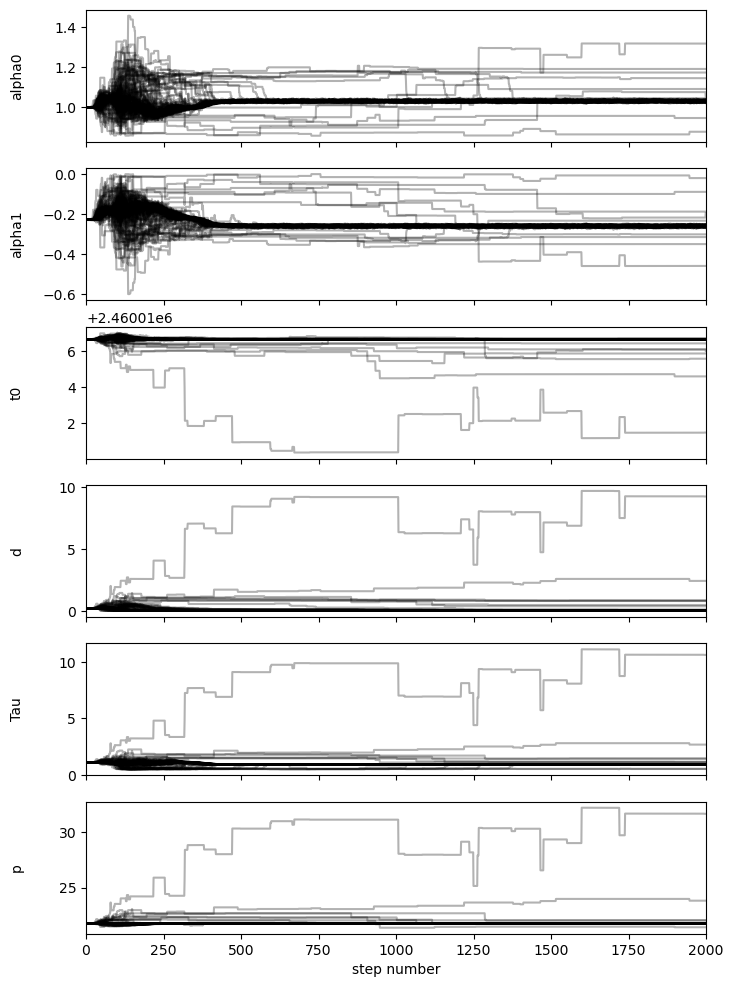

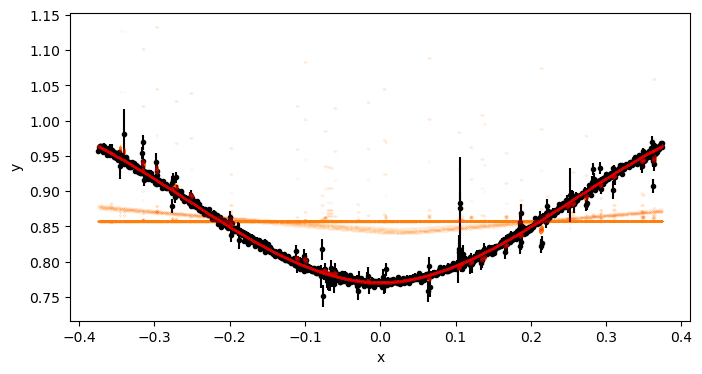

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0306106929524965, -0.2601621593265979, 2460016.6485252036, 0.011675523976868343, 0.9267325257816089, 21.79115033002278
std_p: 0.8587419659016022


In [122]:
mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats  = etvp.run_mcmc_initial_fit_p(
    lc_f_data, 
    [1.0, -0.23, epoch_time_min_ii_hjd, 0.21, 1.11, period_initial], 
    nruns=2000, discard=1500,
    # nruns=1000, discard=600,
    # nruns=20, discard=1,
    pool=-2, 
    plot_chains=True, plot=True, 
    also_return_stats=True,
)

print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
print("std_p:", fit_params_p_stats["std_p"])


In [128]:
lc = lk.LightCurveCollection(lc_combined_dict.values()).stitch(corrector_func=lambda lc: lk.LightCurve(time=lc.time, flux=lc.flux, flux_err=lc.flux_err))

lc.to_csv("tmp/tic106147715.csv")

Adopted period:  21.7912
Min II phase:  0.49236389001065656


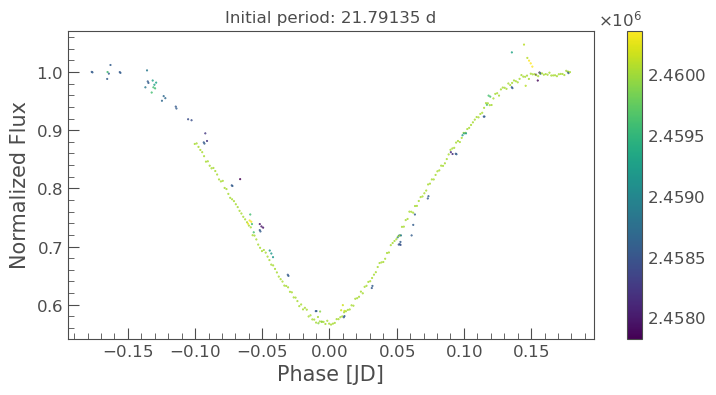

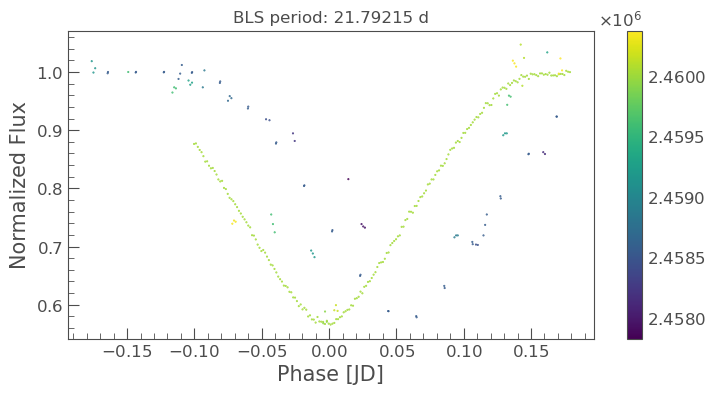

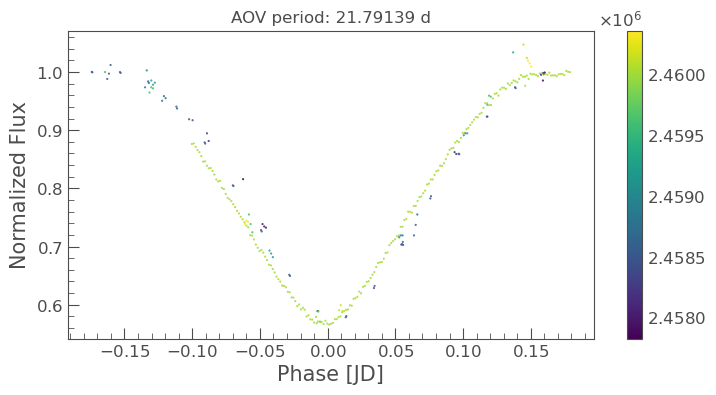

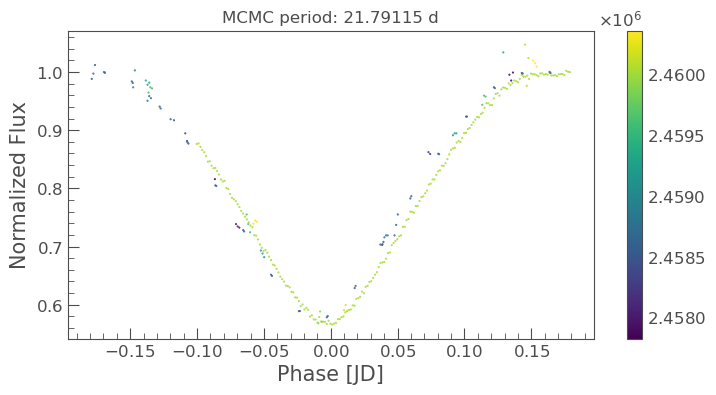

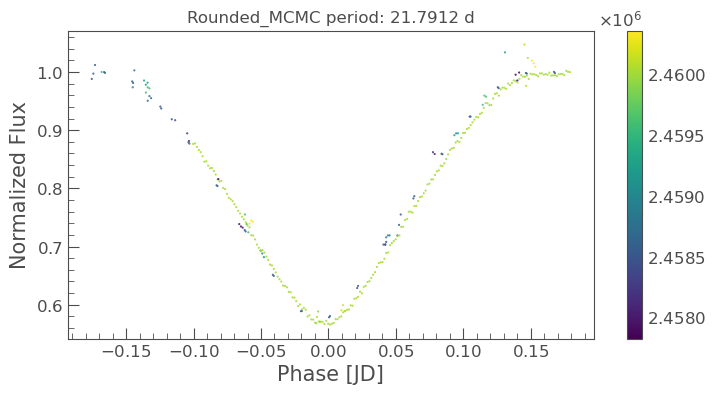

In [18]:
	
period_bls  = 21.79215  # 21.792152172312072 d, HWHM: 0.5433487606606633 , frequency_factor=2
period_aov  = 21.79139	# 21.791392	
period_mcmc = 21.79115  # 21.79115033002278, std_p: 0.8587419659016022, does not converge well
period_rounded  = 21.7912  # MCMC fits the best, but still do not have good precision, rounded it up further

lc = lke.to_normalized_flux_from_mag(lk.LightCurveCollection(lc_combined_dict.values()).stitch(corrector_func=lambda lc: lk.LightCurve(time=lc.time, flux=lc.flux, flux_err=lc.flux_err)))

for per_method, per in dict(Initial=period_initial, BLS=period_bls, AOV=period_aov, MCMC=period_mcmc, Rounded_MCMC=period_rounded).items():
    lc_f = lc.fold(period=per, epoch_time=epoch_time_hjd)
    lc_f = lc_f.truncate(0 - 0.6 * duration_hr / 24, 0 + 0.6 * duration_hr / 24);
    ax = tplt.scatter(lc_f, s=1, c=lc_f.time_original.value);
    ax.set_title(f"{per_method} period: {per} d")

# Cannot tell the difference between TCE period and BLS period, cut 1 digit and choose the best
period_final = period_rounded
print("Adopted period: ", period_final)

# Can precsiely define Min II phase, with period finalized
epoch_phase_min_ii = (epoch_time_min_ii_btjd + period_final - epoch_time_btjd) / period_final
print("Min II phase: ", epoch_phase_min_ii)

## Determine Amplitude

['11.64', '12.26', '11.92']
['11.64', '0.62', '0.28']


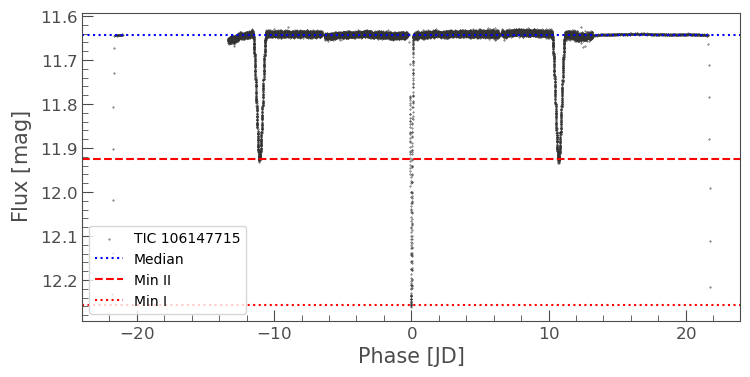

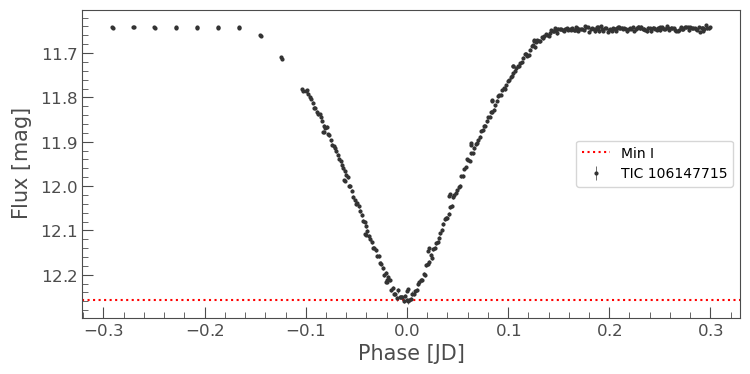

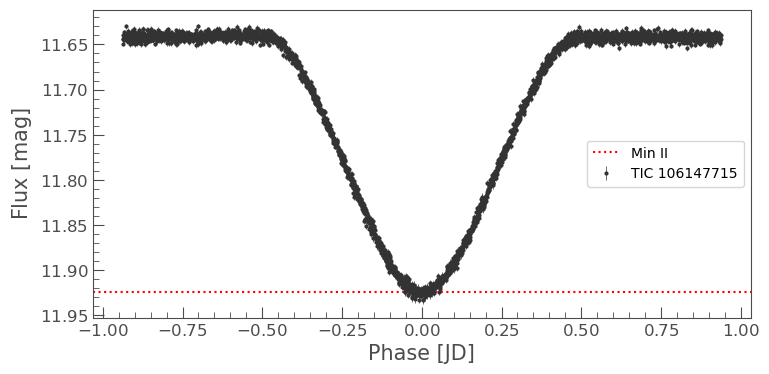

In [19]:
# From TESS data (shifted back to TESS mag)

lc = lc_combined_dict["TESS"]
lc = lc - lc.flux_shift
# max_flux_mag = lc.flux.min().value  #
min_flux_mag = lc.flux.max().value
median_flux_mag = np.nanmedian(lc.flux.value)

lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd, period=period_final).truncate(0 - 5/24/60, 0 + 5/24/60)
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)
min_amp_mag = abs(min_flux_mag - median_flux_mag) 

# fold around Min II, find the min flux
lc_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - 5/24/60, 0 + 5/24/60)
min_ii_flux_mag = np.nanmedian(lc_zoom_min_ii.flux.value)
min_ii_amp_mag = abs(min_ii_flux_mag - median_flux_mag) 

lc_f = lc.fold(epoch_time=epoch_time_hjd, period=period_final * 2)  # 2x period plot
ax = tplt.scatter(lc_f, s=0.5);
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(min_ii_flux_mag, c="red", linestyle="dashed", label="Min II")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.legend();

lc_f_zoom_min_i = lc.fold(epoch_time=epoch_time_hjd, period=period_final).truncate(0 - duration_hr / 24, 0 + duration_hr / 24)
ax = tplt.errorbar(lc_f_zoom_min_i, marker="o");
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.legend();

lc_f_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - duration_hr_min_ii_initial / 24, 0 + duration_hr_min_ii_initial / 24)
ax = tplt.errorbar(lc_f_zoom_min_ii, marker="o");
ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
ax.legend();

print([f"{v:.2f}" for v in [median_flux_mag, min_flux_mag, min_ii_flux_mag]])
print([f"{v:.2f}" for v in [median_flux_mag, min_amp_mag, min_ii_amp_mag]])

In [20]:
median_flux_mag_asassn_v = np.nanmedian(lc_combined_dict["ASAS-SN V"].flux.value)
median_flux_mag_asassn_v

12.147

## Plots for VSX

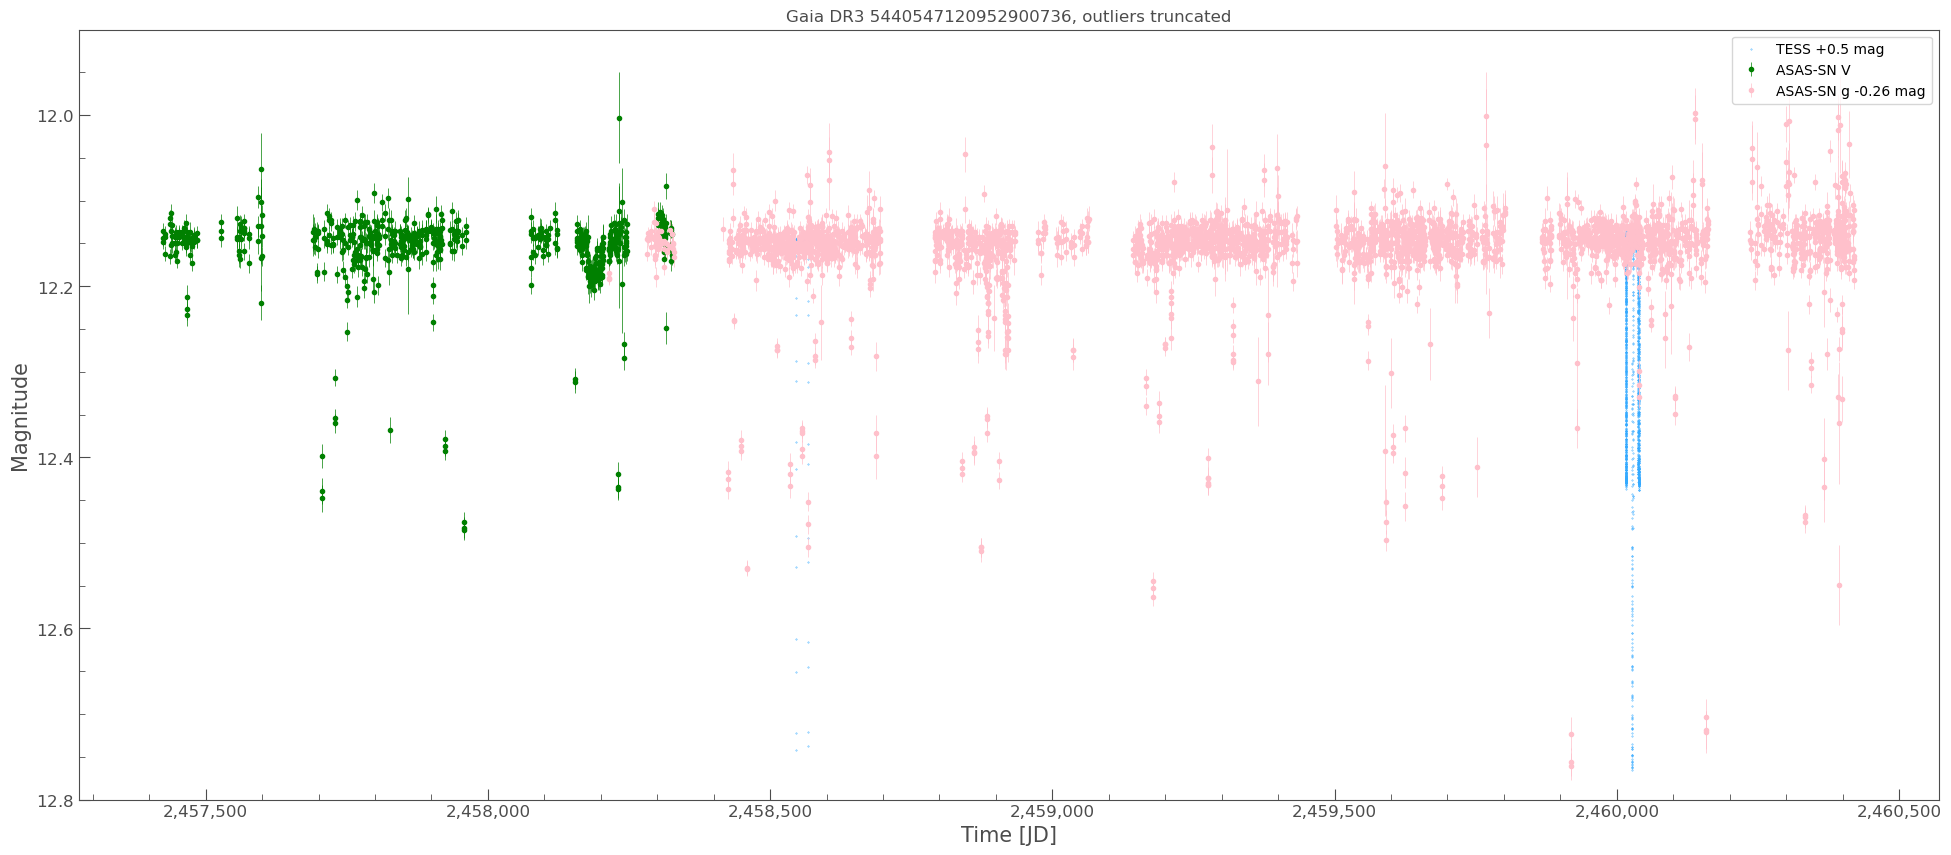

In [21]:
# reload(lkem)
ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(24, 10), target_name=primary_name);
ax.set_ylim(12.8, 11.9);
ax.set_title(ax.get_title() + ", outliers truncated");

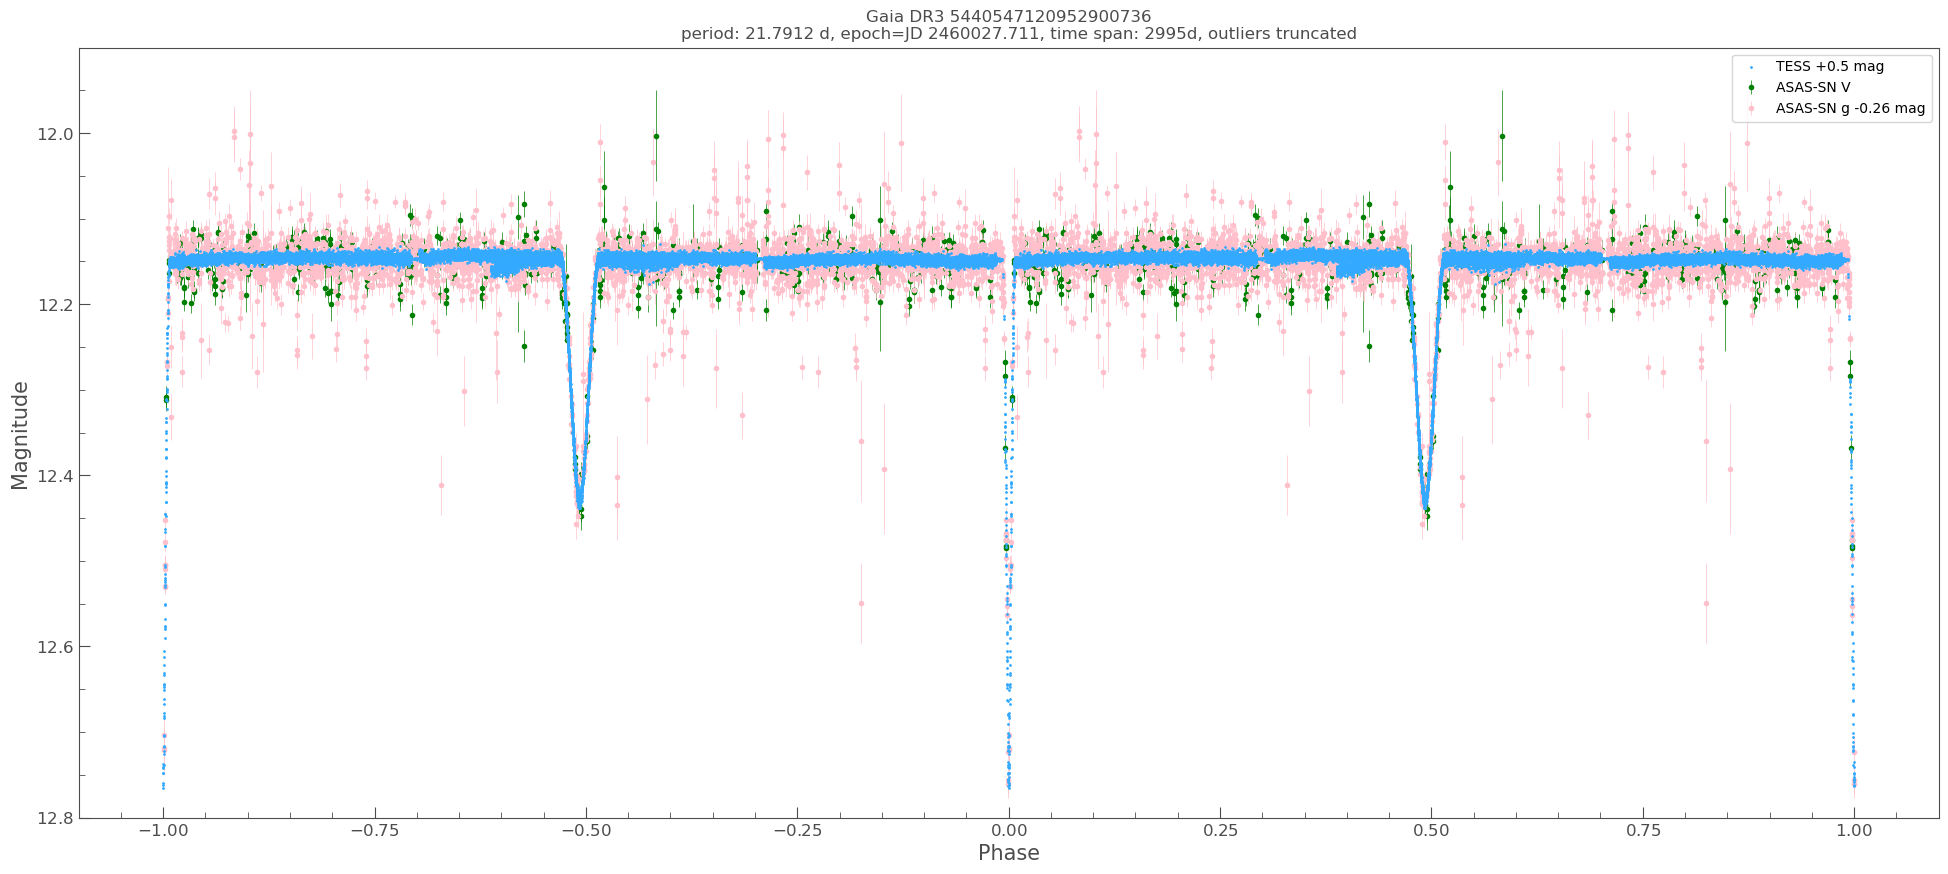

In [52]:
reload(lkem)

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) increase the marker size and move it to the front, to make TESS data more visible, its data is not rather sparse
plot_options[0][1]["s"] = 1  # default 0.1
plot_options[0][1]["zorder"] = 3  # default 2

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ax.set_ylim(12.8, 11.9);
ax.set_title(ax.get_title() + ", outliers truncated");

In [170]:
# reload(lkem)
# ax, lc_f_res = lkem.fold_n_plot_multi_bands(
#     dict(TESS=lc_tess),
#     period=period_final,
#     epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
#     phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
#     figsize=(24, 10),
#     target_name=primary_name,
# );

## VSX Report Table

In [40]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df

In [44]:
import bibs_utils
reload(bibs_utils)

other_names = f"TIC {tic}"  # include TIC, as Gaia DR3 is the primary name
other_names += ",2MASS J10331579-4013413,UCAC4 249-043563,WISEA J103315.79-401341.3"  # from TIC, checked with Vizier
other_names += ",GSC 07714-02184"  # Vizier, https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ662464d61cfcb6&-out.add=.&-source=I/255/out&GSC=0771402184

remarks = f"Eccentric system. Min II at phase {epoch_phase_min_ii:.2f}, amplitude {min_ii_amp_mag:.2f} TESS, duration {100 * duration_hr_min_ii_initial / 24 / period_final:.0f}% (longer than Min I)."
    
revision_comment = "Period, epoch, eclipse duration from TESS and ASAS-SN data. Magnitudes from ASAS-SN V data. Amplitudes from TESS data. Spectral type and position from Gaia DR3."

BIBS = bibs_utils.BIBS

vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    Variable_Type="EA",
    Spectral_Type="F",  # from Gaia DR3 astrophysical parameters
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"{median_flux_mag_asassn_v:.2f}",
    Maximum_Magnitude_band="V",
    Minimum_Magnitude=f"{min_amp_mag:.2f}",
    Minimum_Magnitude_band="TESS",  
    Minimum_Is_Amplitude=True,
    Period=period_final,
    Epoch=epoch_time_hjd,
    Rise_Duration_Pct=f"{100 * duration_hr_min_i_initial / 24 / period_final:.0f}",
    Discoverer="Gaia collaboration",  
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference0_Name=BIBS.GAIA_DR3_VAR_N,
    Reference0_Bib=BIBS.GAIA_DR3_VAR_B,
    Reference1_Name=BIBS.TESS_N,
    Reference1_Bib=BIBS.TESS_B,
    Reference2_Name=BIBS.TESS_SPOC_N,
    Reference2_Bib=BIBS.TESS_SPOC_B,
    Reference4_Name=BIBS.ASAS_SN_N,
    Reference4_Bib=BIBS.ASAS_SN_B,
)

def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))

# Uploaded plots with  descriptions
print("""
tic106147715_combined_plot.png: Combined light curve - Combined light curve from ASAS-SN and TESS, shifted to ASAS-SN V, outliers truncated.
tic106147715_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot of the target from  ASAS-SN and TESS, shifted to ASAS-SN V, outliers truncated.
""")


Other Names (1 line each):
TIC 106147715
2MASS J10331579-4013413
UCAC4 249-043563
WISEA J103315.79-401341.3
GSC 07714-02184

Eccentric system. Min II at phase 0.49, amplitude 0.28 TESS, duration 4% (longer than Min I).

Type, period, epoch, eclipse duration from TESS and ASAS-SN. Magnitudes from ASAS-SN V. Amplitudes from TESS. Spectral type and position from Gaia DR3.


,Field,Value
0,Position,"158.31583613027, -40.22819577789"
1,Primary_Name,Gaia DR3 5440547120952900736
2,Other_Names,"TIC 106147715,2MASS J10331579-4013413,UCAC4 249-043563,WISEA J103315.79-401341.3,GSC 07714-02184"
3,Variable_Type,EA
4,Spectral_Type,F
5,Spectral_Type_Uncertain,False
6,Maximum_Magnitude,12.15
7,Maximum_Magnitude_band,V
8,Minimum_Magnitude,0.62
9,Minimum_Magnitude_band,TESS



tic106147715_combined_plot.png: Combined light curve - Combined light curve from ASAS-SN and TESS, shifted to ASAS-SN V, outliers truncated.
tic106147715_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot of the target from  ASAS-SN and TESS, shifted to ASAS-SN V, outliers truncated.



# Scratch